In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
#from jupyterthemes import jtplot
#jtplot.style()
plt.style.use('ggplot')


#### Задаем функции для определения и визуализации доверительного интервала, а также проведения тестов (точный и асимптотический):

In [2]:
#Считает доверительный интервал (асимптоитческий, либо точный)
def ci_asy(x, alpha, asy=False):
    n = x.size
    if asy:
        margin = stats.norm().ppf(1-alpha/2) * (x.var(ddof=1)/n)**0.5
    else:
        margin = stats.t(n-1).ppf(1-alpha/2) * (x.var(ddof=1)/n)**0.5
    return x.mean() - margin, x.mean() + margin

In [3]:
#Строит визуализацию либо ассимптотического, либо точного доверительного интервала
def norm_conf_int(data, alpha=0.05, margin=5, asy=False):
    n=data.size
    mean = data.mean()
    std = data.std(ddof=1)/np.sqrt(n)
    
    plt.figure(figsize=(10,5))
    xs = np.linspace(mean - margin, mean + margin)
    pdf = stats.norm(mean, std).pdf(xs)
    
    plt.plot(xs, pdf)
    plt.ylabel('$f(x)$', fontsize=18)
    plt.xlabel('$x$', fontsize=18)
    
    if asy:
        left, right = stats.norm.interval(1 - alpha, loc=mean, scale=std)
    else:
        left, right = stats.t.interval(1 - alpha, df=(n-1), loc=mean, scale=std)
    
    for i in [left, right]: 
        y_max = plt.ylim()[1]
        plt.axvline(i, color="blue", linestyle='dashed', lw=2)
        
        if i == left:
            xq = np.linspace(mean - margin, left)
        else:
            xq = np.linspace(right, mean + margin)
        
        text_margin = 0.05
        plt.text(i + text_margin, 0.8*y_max, round(i, 2), color="blue", fontsize=14)
        yq = stats.norm(mean, std).pdf(xq)
        plt.fill_between(xq, 0, yq, color='blue', alpha=0.3)

    return left, right

In [4]:
# функция для визуализации асимптотического теста:
def asy_mean_test(mean_hat, std_hat, mu_0=0, alpha=0.05, alternative='two-sided', margin=3):
    z_obs = (mean_hat - mu_0)/std_hat
    
    if alternative == 'two-sided':
        p_value = 2 * (1 - stats.norm().cdf(np.abs(z_obs)))
        z_crit = stats.norm().ppf(1 - alpha/2)
        
        statistics = ['-z_crit', 'z_crit', '-z_obs', 'z_obs']
        params = dict(zip(statistics, [(-z_crit, -0.6, -margin, -z_crit, 'b'), 
                                       (z_crit, 0.05, z_crit, margin, 'b'),
                                       (-z_obs, -0.6, -margin, -z_obs, 'r'), 
                                       (z_obs, 0.1, z_obs, margin, 'r')]))
    
    if alternative == 'less':
        p_value = stats.norm().cdf(z_obs)
        z_crit = stats.norm().ppf(1 - alpha)
        
        statistics = ['-z_crit', '-z_obs']
        params = dict(zip(statistics, [(-z_crit, -0.6, -margin, -z_crit, 'b'), 
                                       (-z_obs, -0.6, -margin, -z_obs, 'r')]))

    if alternative == 'larger':
        p_value = 1 - stats.norm().cdf(z_obs)
        z_crit = stats.norm().ppf(1 - alpha)
        
        statistics = ['z_crit', 'z_obs']
        params = dict(zip(statistics, [(z_crit, 0.05, z_crit, margin, 'b'),
                                       (z_obs, 0.1, z_obs, margin, 'r')]))
    
    
    plt.figure(figsize = (10, 5))
    x = np.linspace(-margin, margin)
    pdf = stats.norm().pdf(x)

    plt.plot(x, pdf, color="black")
    plt.ylabel("$f(x)$", fontsize=16)
    plt.xlabel("$x$", fontsize=16)
    y_max = plt.ylim()[1]
    
    for i in range(len(statistics)):
        statistic, text_margin, left_bound, right_bound, color = params[statistics[i]]
        
        plt.axvline(statistic, color=color, linestyle="--", lw=2)
        h = 0.8 if statistics[i].split('_')[-1] == 'crit' else 0.6
        plt.text(statistic + text_margin, 
                 h*y_max, round(statistic, 2), color=color, fontsize=16)
        
        xq = np.linspace(left_bound, right_bound)
        yq = stats.norm().pdf(xq)
        plt.fill_between(xq, 0, yq, color=color, alpha=0.2)
    
    return p_value

In [5]:
# функция для визуализации теста Стьюдента (зависимая выборка)
def mean_test_t(data, mu_0=0, alpha=0.05, alternative='two-sided', margin=3, test = 't'):
    n = data.size
    mean = data.mean()
    var = data.var(ddof=1)/n
    
    t_obs = mean/np.sqrt(var)
    
    if alternative == 'two-sided':
        p_value = 2*(1-stats.t.cdf(np.abs(t_obs), n-1)) 
        t_crit = stats.t(n - 1).ppf(1-alpha/2) 
        
        statistics = ['-t_crit', 't_crit', '-t_obs', 't_obs']
        params = dict(zip(statistics, [(-t_crit, -0.6, -margin, -t_crit, 'b'), 
                                       (t_crit, 0.05, t_crit, margin, 'b'),
                                       (-t_obs, -0.6, -margin, -t_obs, 'r'), 
                                       (t_obs, 0.1, t_obs, margin, 'r')]))
    
    if alternative == 'less':
        p_value = stats.t.cdf(t_obs, n-1)
        t_crit = stats.t(n-1).ppf(1 - alpha)
        
        statistics = ['-t_crit', '-t_obs']
        params = dict(zip(statistics, [(-t_crit, -0.6, -margin, -t_crit, 'b'), 
                                       (-t_obs, -0.6, -margin, -t_obs, 'r')]))

    if alternative == 'larger':
        p_value = 1 - stats.t.cdf(t_obs, n-1)
        t_crit = stats.t(n-1).ppf(1 - alpha)
        
        statistics = ['t_crit', 't_obs']
        params = dict(zip(statistics, [(t_crit, 0.05, t_crit, margin, 'b'),
                                       (t_obs, 0.1, t_obs, margin, 'r')]))
    
    
    plt.figure(figsize = (10, 5))
    x = np.linspace(-margin, margin)
    pdf = stats.norm().pdf(x)

    plt.plot(x, pdf, color="black")
    plt.ylabel("$f(x)$", fontsize=16)
    plt.xlabel("$x$", fontsize=16)
    y_max = plt.ylim()[1]
    
    for i in range(len(statistics)):
        statistic, text_margin, left_bound, right_bound, color = params[statistics[i]]
        
        plt.axvline(statistic, color=color, linestyle="--", lw=2)
        h = 0.8 if statistics[i].split('_')[-1] == 'crit' else 0.6
        plt.text(statistic + text_margin, 
                 h*y_max, round(statistic, 2), color=color, fontsize=16)
        
        xq = np.linspace(left_bound, right_bound)
        yq = stats.norm().pdf(xq)
        plt.fill_between(xq, 0, yq, color=color, alpha=0.2)
    
    return p_value

***

### Данные о весе пциентов до и после приема препрата от анорексии, была ли терапия против эффективна?

In [6]:
anorex = pd.read_csv('anorexia.txt', sep='\t')

In [7]:
anorex.info() #проверим что все нормально считальсь в нужном формате

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Before  29 non-null     float64
 1   After   29 non-null     float64
dtypes: float64(2)
memory usage: 592.0 bytes


In [8]:
# lowercase + новые колонки с признаками
anorex.columns = anorex.columns.str.lower()
anorex['diff'] = anorex['after'] - anorex['before'] # Абсолютное изменение
anorex['gain'] = np.where(anorex['diff'] > 0, 1, -1) # Повысился ли вес (1 - да, 0 - нет)
#anorex['pct_diff'] = anorex['diff'] / anorex['before'] # % изменения
#anorex['pct_diff'] = anorex['pct_diff'].round(4)


#### Прежде чем переходить к гипотезам, посмотрим с выборкой какого типа мы имеем дело. Ожидается конечно, что выборка по весам людей должна быть из нормального распределения (так как вес людей в целом подчиняется нормальному распределению), и изменения тоже будут из нормального распределения.
##### Для начала глянем на визуальное распределение изменения веса после терапии:

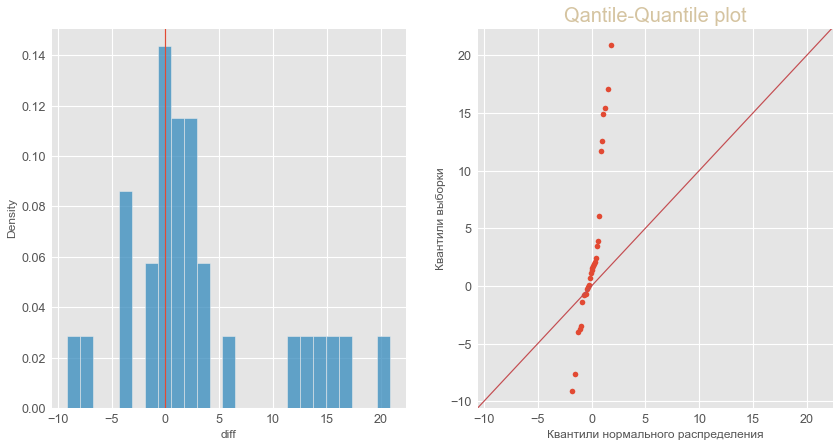

In [9]:
from statsmodels.graphics.gofplots import qqplot

plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.axvline(0)
sns.histplot(anorex['diff'], bins=25, stat='density')

plt.subplot(1,2,2)
qqplot(anorex['diff'], line='45', ax=plt.subplot(1,2,2))
plt.title('Qantile-Quantile plot', fontsize=20)
plt.xlabel('Квантили нормального распределения')
plt.ylabel('Квантили выборки');

#### Гистограмма немного похожа на нормальную (но отдаленно), а вот Q-Q плот довольно четко намекает на нормальность (ось X - теоретические квинтили, ось Y - реальные кватнили выборки), поскольку точки на графике формируют практически прямую линию, можно сделать вывод о нормальности распределения изменений. Увеличенный в отличие от диагонали наклон свидетельствует о высокой дисперсии.
##### Проверим нормальность другим способом:

In [10]:
# H(0) - Данные принадлежат нормальному распределению, но если p-value ниже порога (0.05)
# то отвергаем гипотезу о нормальности
stats.normaltest(anorex['diff'])

NormaltestResult(statistic=4.831292931360961, pvalue=0.08930958467426525)

#### Видим что по p-value чуть больше 0.05, исходя из чего мы не можем отвергнуть H(0) гипотезу, и говорим что мы допускаем что распределение нормальное.
#### Итого, у нас есть 2 зависмые выборки (измерения на одних и тех же пациентах), с нормально распределенными изменениями, из которых мы взяли данные об изменении веса после терапии. Чтобы оценить эффективность терапии, сравним изменения по критерию Стьюдента, гипотезы:
$H_{0}: \mu_{diff} = 0 \ \rightarrow \text{Нет эффекта}$ </br>
$H_{1}: \mu_{diff} > 0 \rightarrow \text{Есть положительный эффект}$
</br>


##### Но дня начала остроим доверительный интервал (0.05) (точный ($\bar x \pm t_{1 - \frac{\alpha}{2}} \cdot \sqrt{\frac{\hat{\sigma}^2}{n}}$), дисперсия генральной совкупности нам не известна, и асимптотический ($
\bar x \pm z_{1 - \frac{\alpha}{2}} \cdot \sqrt{\frac{\hat{\sigma}^2}{n}}.
$), просто для сравнения):


In [11]:
#Точный и Асимптотический интервал:
print('Точный доверительный интервал:', ci_asy(anorex['diff'], alpha=0.05))
print('Асомптотический доверитльный интервал:', ci_asy(anorex['diff'], alpha=0.05, asy=True))

Точный доверительный интервал: (0.22689015835877635, 5.7869029450894995)
Асомптотический доверитльный интервал: (0.3469212486640765, 5.666871854784199)


Видим что точный чуть шире, но не меняет картины (0 не попадает), визуализируем:

(0.22689015835877635, 5.7869029450894995)

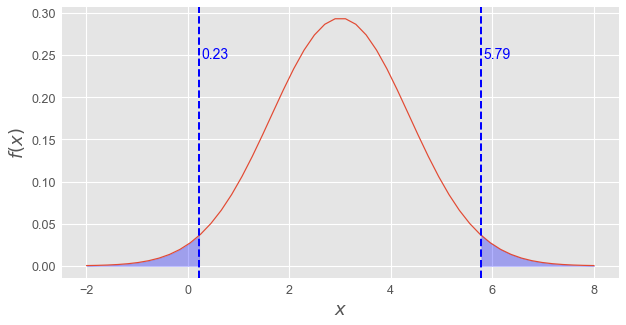

In [12]:
data = anorex['diff']
alpha = 0.05
norm_conf_int(data, alpha, margin = 5)

#### Видим, что с вероятностью 95%, в результате терапии вес пациента увеличится на 0.23-5.79 (каких то едениц, подозреваю что это фунты?). Нулевое (а тем более отрицательное) изменение не попадает в доверительный интервал. Соответственно можно сделать вывод, что терапия эффективна (на 95% доверительном интервале).
#### Дополнительно проверим по критерию Стьюдента:

Необходимый критерий (ноль в числителе поскольку ноль в основной гипотезе):

$$
t\ =\ \dfrac{\bar{d}-0}{\sqrt{\dfrac{s^{2}}{n}}}\sim t\left(n-1\right)
$$ </br>
Где $$s^{2}=\frac{1}{n-1} \sum_{i=1}^{n}\left(d_{i}-\bar{d}\right)^{2}$$

In [13]:
mean = anorex['diff'].mean()
alpha = 0.05
n = anorex['diff'].size

t_obs = mean/np.sqrt(anorex['diff'].var(ddof=1)/anorex['diff'].size)  # наблюдаемое
t_crit = stats.t(n - 1).ppf(1-alpha)                                  # критическое
p_val = 2*(1-stats.t.cdf(np.abs(t_obs), n-1))       # p-value

In [14]:
t_obs, t_crit, p_val

(2.2155878439311656, 1.701130934265931, 0.03502259756218873)

##### Визуализируем тест:

0.017511298781094364

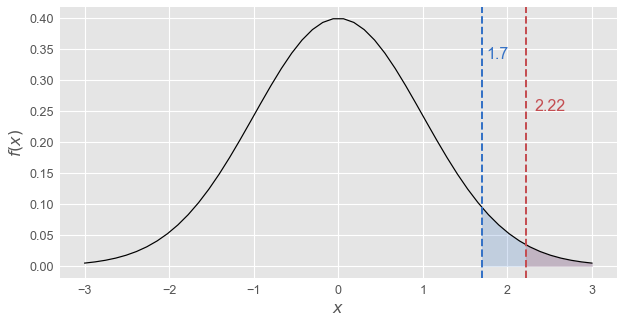

In [15]:
mean_test_t(anorex['diff'], margin=3, alternative='larger')

#### Наблюдаемое значение t статистики (2.22) больше критического (1.7), соответственно отвергаем $H_{(0)}$ гипотезу о том что средний вес пациента не меняется в результате терапии в пользу альтернативной гипотезы (средний вес увеличивается).

#### Ответ: терапия эффективна
***

### Изменились ли в среднем цены на недвижимость в одном из рейонов Сиэтла за год?

In [16]:
seattle = pd.read_csv('seattle.txt', sep = '\t')
seattle.columns = seattle.columns.str.lower()

In [17]:
seattle.columns = seattle.columns.str.lower()

In [18]:
price_1 = seattle[seattle['year'] == 2001]['price']
price_2 = seattle[seattle['year'] == 2002]['price']

#### Проверим нормальность выборки:

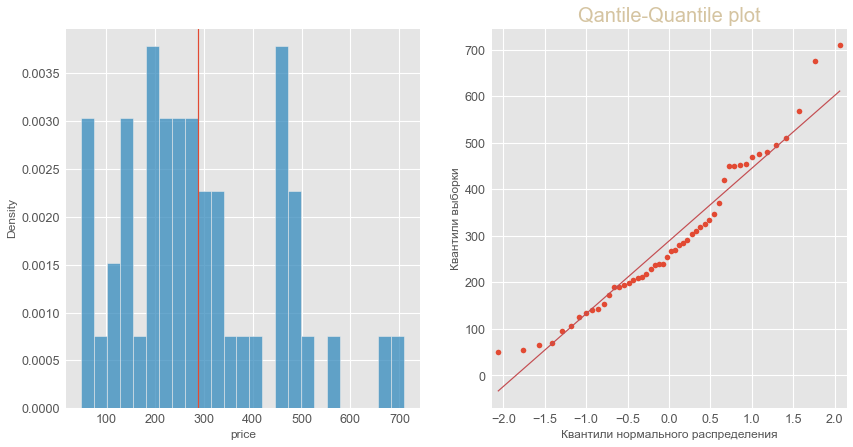

In [19]:
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.axvline(price_1.mean())
sns.histplot(price_1, bins=25, stat='density')

plt.subplot(1,2,2)
qqplot(price_1, line='s', ax=plt.subplot(1,2,2))
plt.title('Qantile-Quantile plot', fontsize=20)
plt.xlabel('Квантили нормального распределения')
plt.ylabel('Квантили выборки');

In [20]:
stats.normaltest(price_1)

NormaltestResult(statistic=4.183128235236117, pvalue=0.12349382580840151)

##### Распределение цен за 2001 год похоже на нормальное, по крайней мере по QQ плоту, по normaltest-у тоже проходит

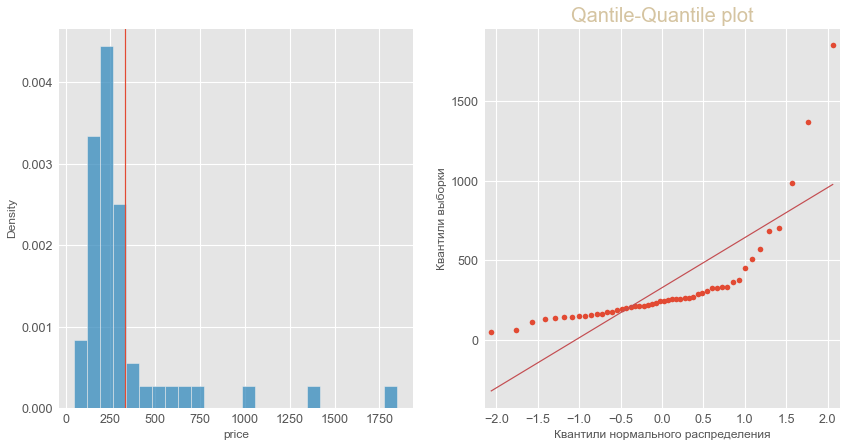

In [21]:
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.axvline(price_2.mean())
sns.histplot(price_2, bins=25, stat='density')

plt.subplot(1,2,2)
qqplot(price_2, line='s', ax=plt.subplot(1,2,2))
plt.title('Qantile-Quantile plot', fontsize=20)
plt.xlabel('Квантили нормального распределения')
plt.ylabel('Квантили выборки');

In [22]:
stats.normaltest(price_2)


NormaltestResult(statistic=58.98743414016329, pvalue=1.5525350931306117e-13)

##### А вот распределение выборки за 2002 год не проходит ни визуально, ни по нормалтесту.
#### Для сравнения средних будем пользоваться ЦПТ, и z-тестом:

$$
z=\dfrac{\bar{x}-\bar{y}}{\sqrt{\dfrac{\hat{\sigma}_{x}^{2}}{n_x}+\dfrac{\hat{\sigma}_{y}^{2}}{n_y}}} \sim N(0,1)
$$

#### Гипотезы: 
$H_{0}: \mu_{2001} = \mu_{2002} \ \rightarrow \text{Цены не изменились}$ </br>
$H_{1}: \mu_{2001} \neq \mu_{2002} \rightarrow \text{Цены изменились}$
</br>

#### Посмотрим на доверительные интервалы (поскольку мы не можем посчитать изменения стоимости конкретных квартир, построим по 1 интервалу для каждого года и сравним их).
##### Точный: 
$$\bar x \pm t_{1 - \frac{\alpha}{2}} \cdot \sqrt{\frac{\hat{\sigma}^2}{n}}$$
##### И ассимптотический:
$$\bar x \pm z_{1 - \frac{\alpha}{2}} \cdot \sqrt{\frac{\hat{\sigma}^2}{n}}$$


In [23]:
# Для 2001 будем строить точный, поскольку выборка похожа на нормальную,
# а для 2002 асммптотический
print('Доверительный интервал для цен 2001 года:', ci_asy(price_1, alpha=0.05))
print('Доверительный интервал для цен 2002 года:', ci_asy(price_2, alpha=0.05, asy=True))

Доверительный интервал для цен 2001 года: (244.08659766721087, 333.7664823327892)
Доверительный интервал для цен 2002 года: (241.43794573260152, 417.07633426739847)


(241.4379457326015, 417.07633426739847)

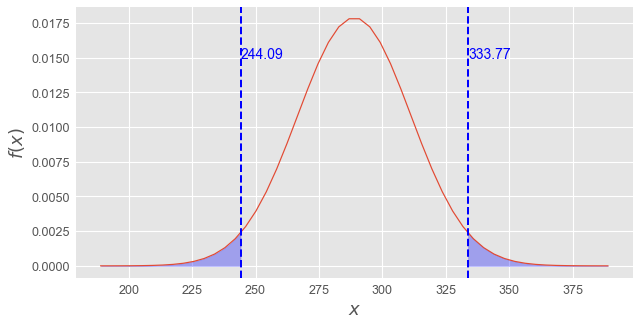

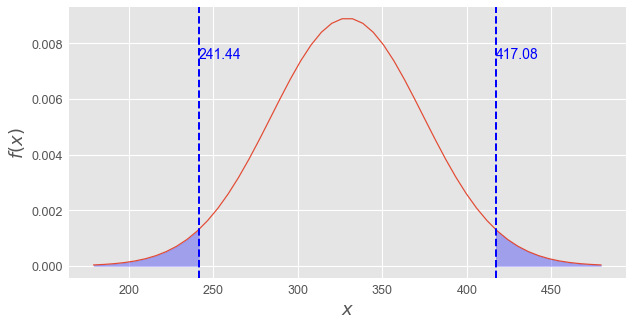

In [24]:
norm_conf_int(price_1, margin = 100)
norm_conf_int(price_2, margin = 150, asy=True)

In [25]:
mean_1 = seattle[seattle['year'] == 2001]['price'].mean()
mean_2 = seattle[seattle['year'] == 2002]['price'].mean()

var_1 = seattle[seattle['year'] == 2001]['price'].var(ddof=1)
var_2 = seattle[seattle['year'] == 2002]['price'].var(ddof=1)

n_1 = len(price_1)
n_2 = len(price_2)

In [26]:
mean_1, mean_2, var_1, var_2, n_1, n_2

(288.92654000000005, 329.25714, 24893.82058743715, 100381.27755306165, 50, 50)

#### Вывод: в отличие от проверки эффективности лекарства, здесь доверительные интервалы не дают очевидного ответа, да, в 2002 году средняя цена была выше, но и дисперсия значительно возрасла, и 95% доверительные интервалы по большей части пересекаются.  Перейдем к проверке гипотезы о равенстев средних:

In [27]:
alpha = 0.05
diff = mean_2 - mean_1
diff_std = np.sqrt(var_1/n_1 + var_2/n_2)

z_obs = diff/diff_std
z_crit = stats.norm.ppf(1-alpha/2)

In [28]:
print(f'+-{z_obs:.3} попадает в ({-z_crit:.3} , {z_crit:.3}), нулевая гипотеза НЕ отвергается')

+-0.806 попадает в (-1.96 , 1.96), нулевая гипотеза НЕ отвергается


0.4204009280147023

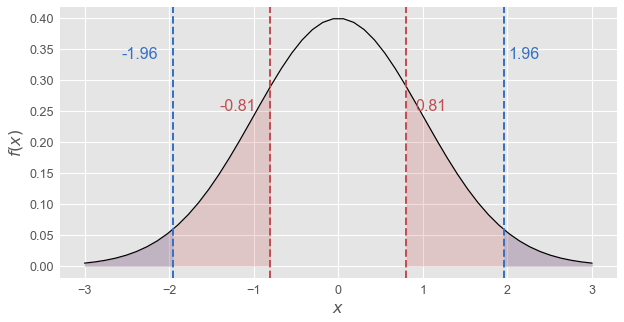

In [29]:
asy_mean_test(diff, diff_std, mu_0=0, alpha=0.05, alternative='two-sided')

#### Вывод: мы не можем отвергнуть нулевую гипотезу. Несмотря на то что средняя стоимсть квартиры в выборке немного выросла, дисперсия возрасла кратно.
#### Ответ: на основании данных выборок нельзя сказать что цены не недвижимось изменились.
***

### В рамках исследования эффективности препарата метилфенидат пациенты с синдромом дефицита внимания и гиперактивности в течение недели принимали либо метилфенидат, либо плацебо. В конце недели каждый пациент проходили тест на способность к подавлению импульсивных поведенческих реакций. На втором этапе плацебо и препарат менялись, и после недельного курса каждый испытуемые проходили второй тест. Был ли эффект от применения препарата?

#### Очень похоже на анализ терапии против анорексии, данные о результатах теста после приема плацебо (без лечения) и после приема лекарства (после терапии). Разделение на 2 группы (сначала плацебо или лекарство) нас не волнует, тем более что об этом нет данных. Выборка парная (зависимая)

In [30]:
methyl = pd.read_csv('methylphenidate.txt', sep = '\t')
methyl.columns = methyl.columns.str.lower()
methyl.head()

,placebo,methylphenidate
0,57,62
1,27,49
2,32,30
3,31,34
4,34,38


#### Поскольку выборка парная, смотреть будем на изменения, для начала проверим из какого они распределения:

In [31]:
methyl['diff'] = methyl['methylphenidate'] - methyl['placebo']
methyl['diff'].describe()

count    24.000000
mean      4.958333
std       7.538188
min     -11.000000
25%      -1.250000
50%       5.000000
75%       8.500000
max      22.000000
Name: diff, dtype: float64

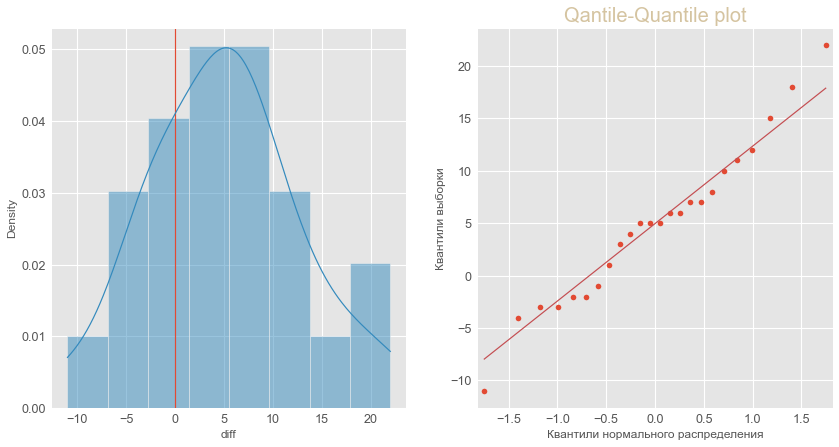

In [32]:
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.axvline(0)
sns.histplot(methyl['diff'], bins=8, stat='density', kde=True)

plt.subplot(1,2,2)
qqplot(methyl['diff'], line='s', ax=plt.subplot(1,2,2))
plt.title('Qantile-Quantile plot', fontsize=20)
plt.xlabel('Квантили нормального распределения')
plt.ylabel('Квантили выборки');

In [33]:
stats.normaltest(methyl['diff'])

NormaltestResult(statistic=0.607684243310523, pvalue=0.7379773678991197)

##### Изменения результатов теста имеют нормальное распрделение.
##### Построим 95% доверительный интервал (точный $\bar x \pm t_{1 - \frac{\alpha}{2}} \cdot \sqrt{\frac{\hat{\sigma}^2}{n}}$) :

In [34]:
print('Точный доверительный интервал:', ci_asy(methyl['diff'], alpha=0.05))

Точный доверительный интервал: (1.775235789319237, 8.141430877347428)


(1.7752357893192365, 8.14143087734743)

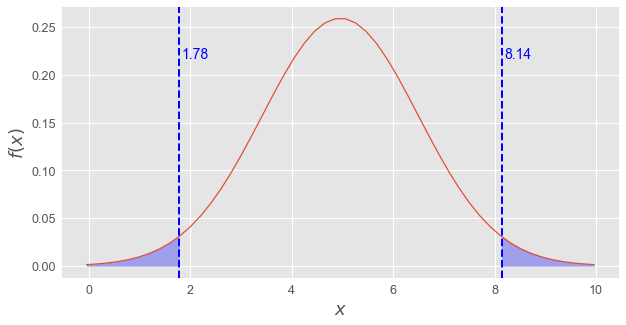

In [35]:
# Визуализируем его:
data = methyl['diff']
alpha = 0.05
norm_conf_int(data, alpha, margin = 5)

#### Вывод: уже исходя из доверительного интервала можно сделать предварительный вывод, эффект от применения препарата был, с вероятностью 95% результаты теста менялись на 1.78-8.14 баллов (правда не известно улучшение это или ухудшение).

#### Теперь проверим гипотезы:
$H_{0}: \mu_{diff} = 0 \ \rightarrow \text{Нет эффекта}$ </br>
$H_{1}: \mu_{diff} \neq 0 \rightarrow \text{Есть эффект}$
</br>
##### Поскольку изменения нормально распределены (да и выборки скорее всего тоже, ибо результаты прохождения почти любых тестов (особенно когда результат по 100 бальной шкале, а не бинарный) подчиняются нормальному распределению, в том числе потому что тесты так устроены, чтобы отделять уникальные (пусть даже в обе стороны) результаты), будем пользоваться тоным тестом Стьюдента:
Необходимый критерий (ноль в числителе поскольку ноль в основной гипотезе):

$$
t\ =\ \dfrac{\bar{d}-0}{\sqrt{\dfrac{s^{2}}{n}}}\sim t\left(n-1\right)
$$ </br>
Где $$s^{2}=\frac{1}{n-1} \sum_{i=1}^{n}\left(d_{i}-\bar{d}\right)^{2}$$

In [36]:
mean = methyl['diff'].mean()
alpha = 0.05
n = methyl['diff'].size

t_obs = mean/np.sqrt(methyl['diff'].var(ddof=1)/methyl['diff'].size)  # наблюдаемое
t_crit = stats.t(n - 1).ppf(1-alpha)                                  # критическое
p_val = 2*(1-stats.t.cdf(np.abs(t_obs), n-1))   

In [37]:
t_obs, t_crit, p_val

(3.222362445123041, 1.7138715277470473, 0.00377148817638151)

In [38]:
print(f'+-{t_obs:.3} НЕ попадает в ({-t_crit:.3} , {t_crit:.3}), нулевая гипотеза отвергается')

+-3.22 НЕ попадает в (-1.71 , 1.71), нулевая гипотеза отвергается


#### По результату теста можем отвергнуть нулевую гипотезу об отсутствии эффекта препарата. Визуализируем результат:

0.00377148817638151

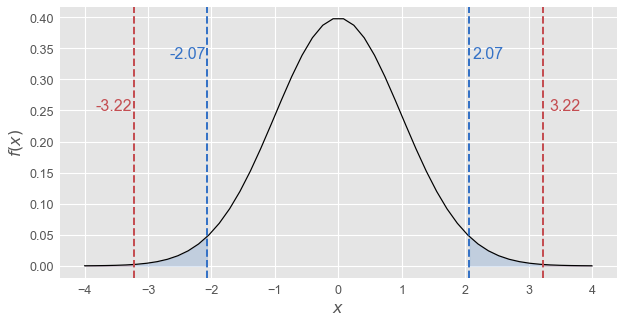

In [39]:
mean_test_t(methyl['diff'], margin=4, alternative='two-sided')

#### Вывод: мы можем отвегнуть нулевую гипотезу об отсутствии эффекта от препарата.
#### Ответ: эффект от препарата есть, что ожидалось после построения 95% оверительного интервала, и подтвердилось проверкой гипотезы.
***

### Влияет ли тип двигателя и коробки передач на расход топлива автомобиля.

In [40]:
cars = pd.read_csv('mtcars.csv', index_col=0)
cars

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2
Valiant,18.1,6,225.0,105,2.76,3.460,20.22,1,0,3,1
Duster 360,14.3,8,360.0,245,3.21,3.570,15.84,0,0,3,4
Merc 240D,24.4,4,146.7,62,3.69,3.190,20.00,1,0,4,2
Merc 230,22.8,4,140.8,95,3.92,3.150,22.90,1,0,4,2
Merc 280,19.2,6,167.6,123,3.92,3.440,18.30,1,0,4,4


##### mpg — расход топлива (миль/галлон) </br>  vs — тип двигателя (0 = V-образный, 1 = рядный) </br>am — тип коробки передач (0 = автоматическая, 1 = ручная).

In [41]:
#Удалим не интересующие нас колонки:
cars = cars[['mpg', 'vs', 'am']]

In [42]:
cars.describe().T

,count,mean,std,min,25%,50%,75%,max
mpg,32.0,20.090625,6.026948,10.4,15.425,19.2,22.8,33.9
vs,32.0,0.437500,0.504016,0.0,0.000,0.0,1.0,1.0
am,32.0,0.406250,0.498991,0.0,0.000,0.0,1.0,1.0


In [43]:
mpg_v = cars.loc[cars['vs'] == 0]['mpg'] # Автомобили с V-образным двигателем
mpg_r = cars.loc[cars['vs'] == 1]['mpg'] # Автомобили с рядным двигателем

mean_v = mpg_v.mean() # Средний расход топлива с V-образным двигателем
mean_r = mpg_r.mean() # Средний расход топлива с рядным двигателем

var_v, var_r = mpg_v.var(), mpg_r.var() # Дисперсии

#### Для сравнения среднего расхода у автомобилей с V-образным двигателем и рядным двигателем сначала посмотрим на распределение данных:

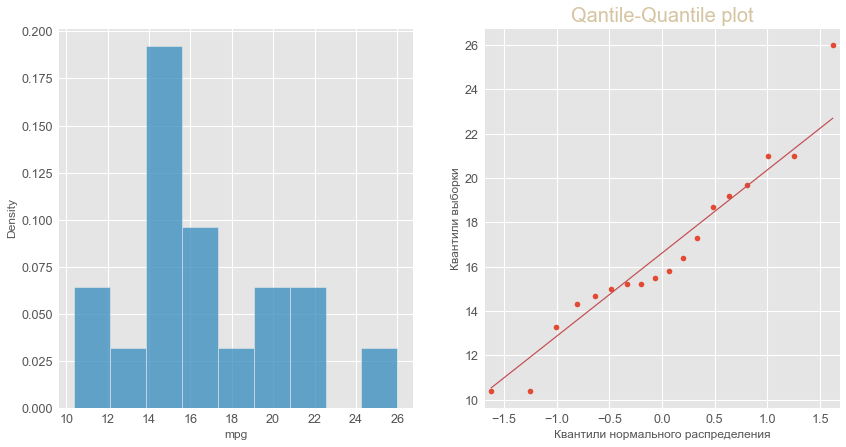

In [44]:
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
#plt.axvline(0)
sns.histplot(mpg_v, bins=9, stat='density')

plt.subplot(1,2,2)
qqplot(mpg_v, line='s', ax=plt.subplot(1,2,2))
plt.title('Qantile-Quantile plot', fontsize=20)
plt.xlabel('Квантили нормального распределения')
plt.ylabel('Квантили выборки');

In [45]:
stats.normaltest(mpg_v)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


NormaltestResult(statistic=2.188932492020612, pvalue=0.3347182164610566)

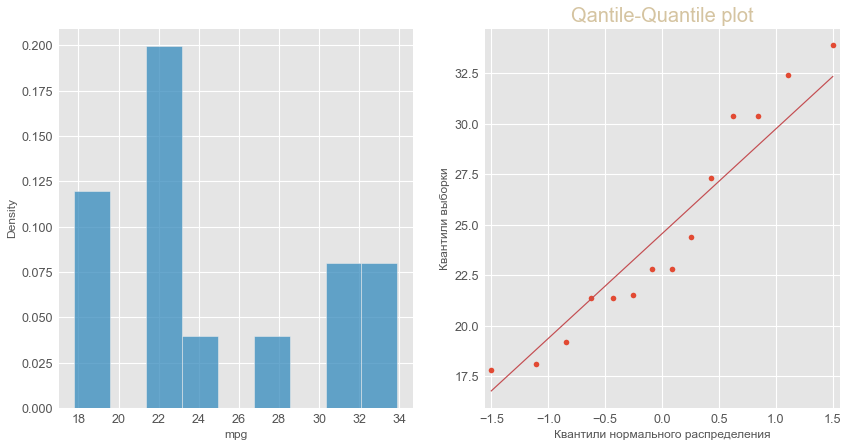

In [46]:
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
#plt.axvline(0)
sns.histplot(mpg_r, bins=9, stat='density')

plt.subplot(1,2,2)
qqplot(mpg_r, line='s', ax=plt.subplot(1,2,2))
plt.title('Qantile-Quantile plot', fontsize=20)
plt.xlabel('Квантили нормального распределения')
plt.ylabel('Квантили выборки');

In [47]:
stats.normaltest(mpg_r)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


NormaltestResult(statistic=2.058440429153653, pvalue=0.3572854579629627)

#### По QQ плоту оба вроде бы похожи на нормальные, по нормалтесту тоже проходят, чтож, не нравятся мне допущения нормальности, но сделаем его в очередной раз

***

####  К вопросу об ошибках первого рода: в предыдущих пунктах вам могло потребоваться проверить несколько гипотез для одной и той же выборки подряд. Допустим, вы проверяли четыре гипотезы: проверка нормальности каждой из подвыборок, равенство дисперсий и равенство средних. Каждую из гипотез вы проверяли на уровне значимости 0.05. Вопрос: какой уровень значимости получился у всей процедуры (то есть проверяя все четыре гипотезы вместе, какова вероятность сделать хотя бы одну ошибку первого рода)? Почему? Как думаете, как с этим можно бороться?

In [48]:
mistake_prob_005 = 1 - 0.95**4
mistake_prob_001 = 1 - 0.99**4
print("""Вероятность сделать хотябы одну ошибку первого рода
проверяя 4 гипотезы на уровне значимости 0.05 = """, round(mistake_prob_005, 5))
print("""Вероятность сделать хотябы одну ошибку первого рода
проверяя 4 гипотезы на уровне значимости 0.01 = """, round(mistake_prob_001, 5))


Вероятность сделать хотябы одну ошибку первого рода
проверяя 4 гипотезы на уровне значимости 0.05 =  0.18549
Вероятность сделать хотябы одну ошибку первого рода
проверяя 4 гипотезы на уровне значимости 0.01 =  0.0394


#### Вывод: вероятность хотябы одной ошибки первого рода при проверке 4 гипотез на уровне значимости 0.05 = 18.5%. Считается как обратная вероятность события "ноль ошибок первого рода" (0.95^4). Бороться с этим можно уменьшая уровень значимости, например при проверке 4 гипотез на уровне значимости 0.01, вероятность хотябы одной ошибки = 4%
***